[(0.8246211251235323, -3.2456798408617948, -0.5, 0.0), (0.28284271247461906, -1.1344640137963142, 0.5, 0.0), (0.4242640687119285, 2.0071286397934789, 0.0, 0.5)]
pose: [ 0.12121153  0.12075038  6.31895693]weight: 7.33912641382e-306
pose: [ 0.16900561  0.01907261  6.43538199]weight: 0.0
pose: [ 0.0670978  -0.04489751  6.34093012]weight: 0.0
pose: [ 0.10800879 -0.05783627  6.30005685]weight: 0.0
pose: [  6.50346138e-02   4.91198865e-03   6.28682845e+00]weight: 0.0
pose: [-0.06308568  0.08030141  6.27567928]weight: 6.48580096294e-130
pose: [-0.03776613  0.04710442  6.09367253]weight: 6.84238514555e-159
pose: [-0.04931843 -0.03260455  6.56013988]weight: 0.0
pose: [ 0.05614032 -0.0993672   6.44285385]weight: 0.0
pose: [ 0.01108673  0.00948208  6.39349532]weight: 6.51051235258e-227
pose: [ -4.37834034e-03   6.04174771e-02   6.25028411e+00]weight: 2.82365602033e-212
pose: [ 0.27349427  0.02461585  6.48232591]weight: 0.0
pose: [-0.10742523 -0.08247087  6.28916033]weight: 0.0
pose: [-0.06615365 

pose: [-0.32587425  0.15518463  6.22415851]weight: 0.01
pose: [-0.32587425  0.15518463  6.22415851]weight: 0.01
pose: [-0.32587425  0.15518463  6.22415851]weight: 0.01
pose: [-0.32587425  0.15518463  6.22415851]weight: 0.01
pose: [-0.32587425  0.15518463  6.22415851]weight: 0.01
pose: [-0.32587425  0.15518463  6.22415851]weight: 0.01
pose: [-0.32587425  0.15518463  6.22415851]weight: 0.01
pose: [-0.32587425  0.15518463  6.22415851]weight: 0.01
pose: [-0.32587425  0.15518463  6.22415851]weight: 0.01
pose: [-0.32587425  0.15518463  6.22415851]weight: 0.01
pose: [-0.32587425  0.15518463  6.22415851]weight: 0.01
pose: [-0.32587425  0.15518463  6.22415851]weight: 0.01
pose: [-0.32587425  0.15518463  6.22415851]weight: 0.01
pose: [-0.32587425  0.15518463  6.22415851]weight: 0.01
pose: [-0.32587425  0.15518463  6.22415851]weight: 0.01
pose: [-0.32587425  0.15518463  6.22415851]weight: 0.01
pose: [-0.32587425  0.15518463  6.22415851]weight: 0.01
pose: [-0.32587425  0.15518463  6.22415851]weigh

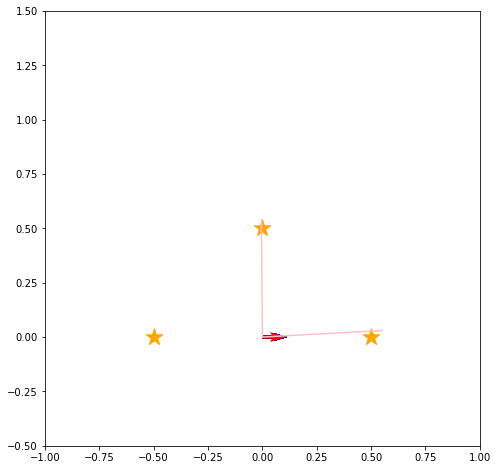

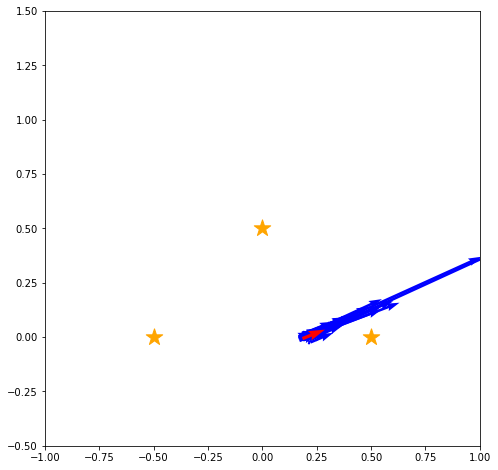

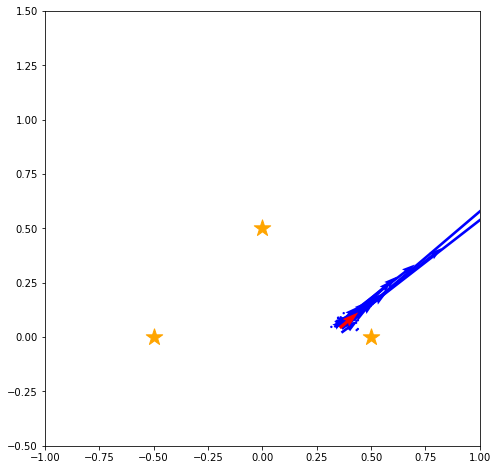

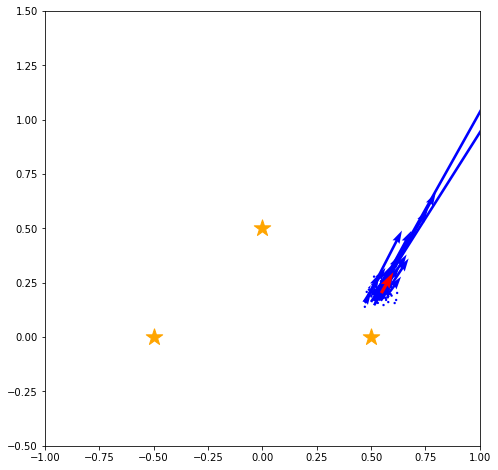

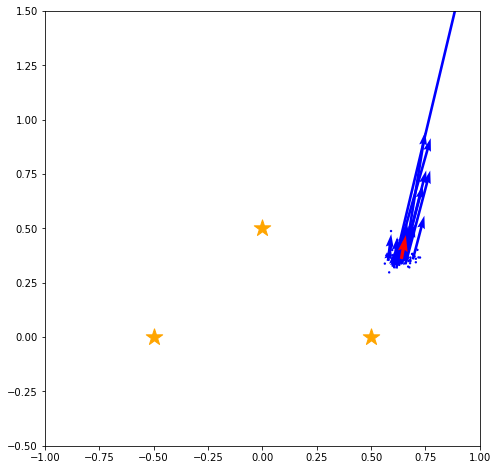

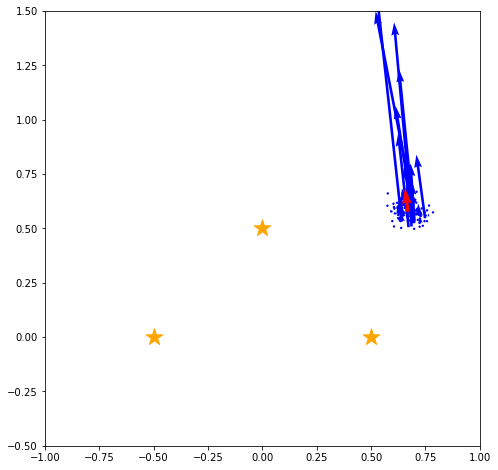

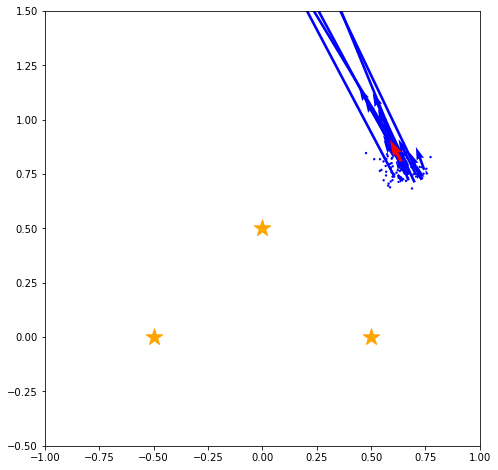

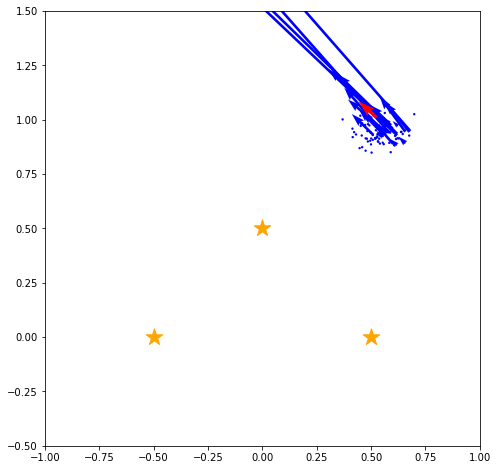

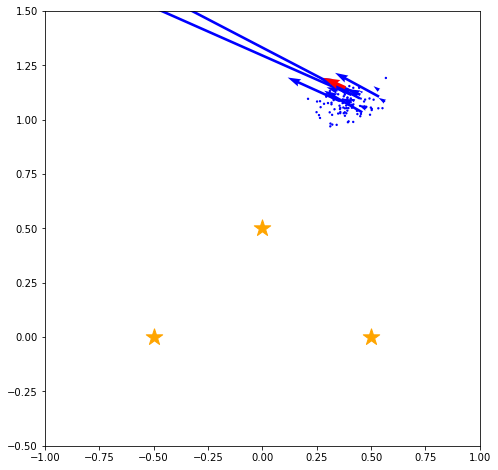

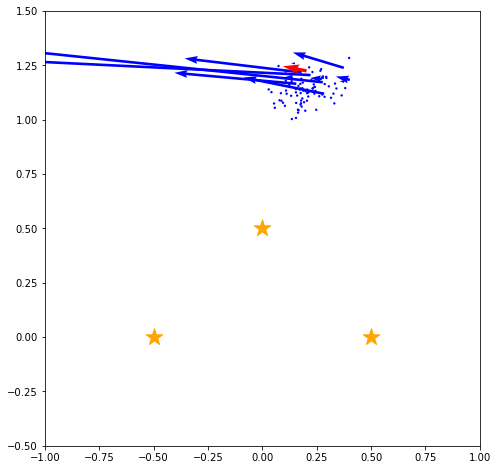

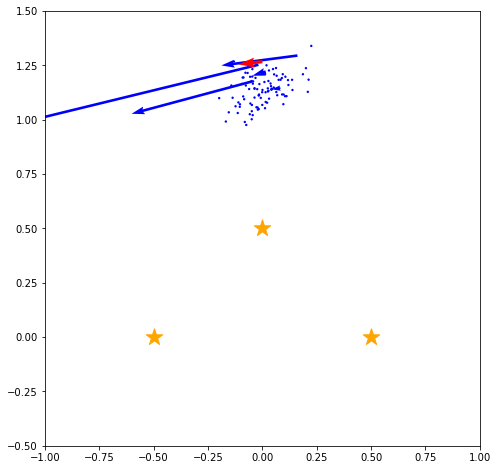

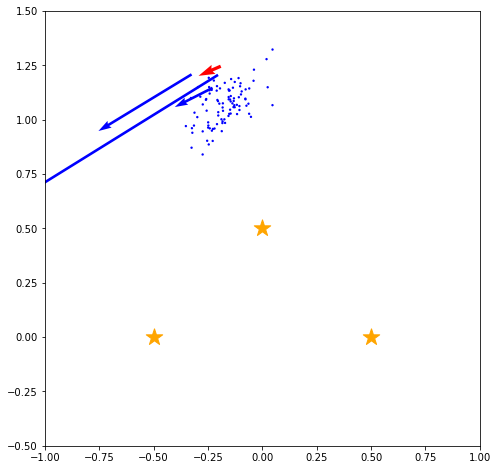

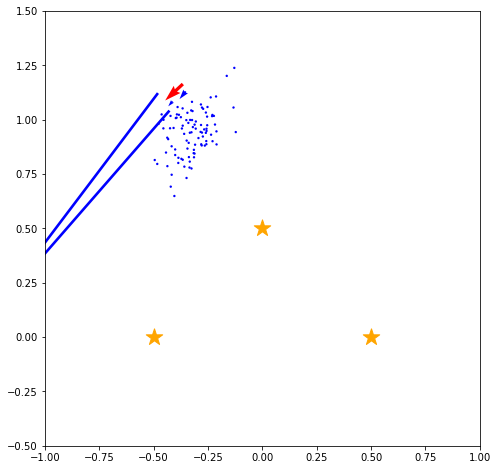

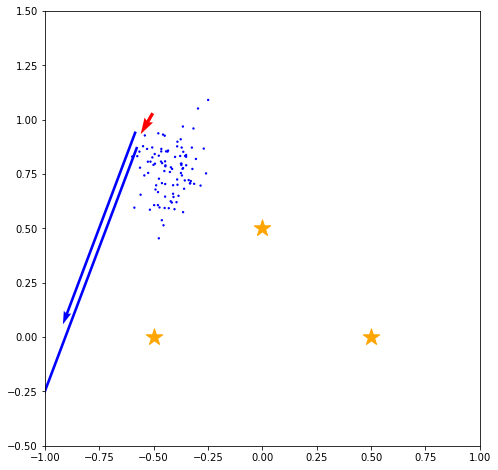

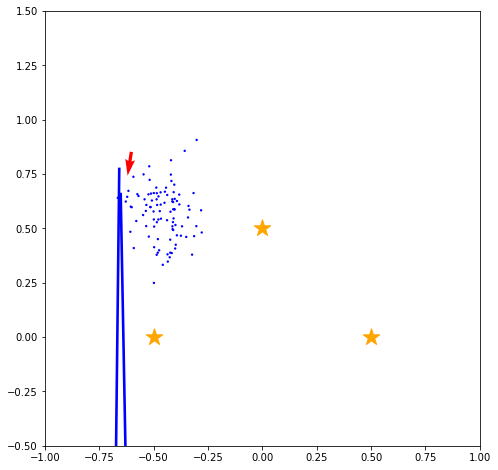

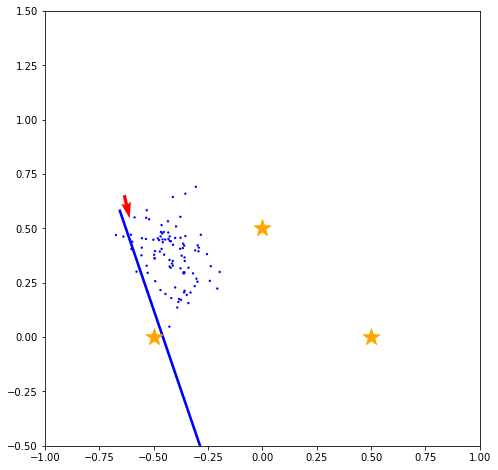

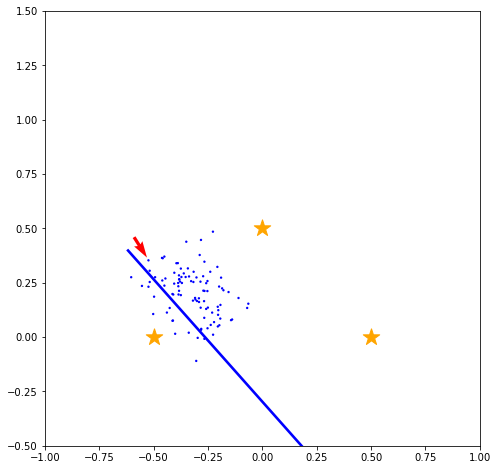

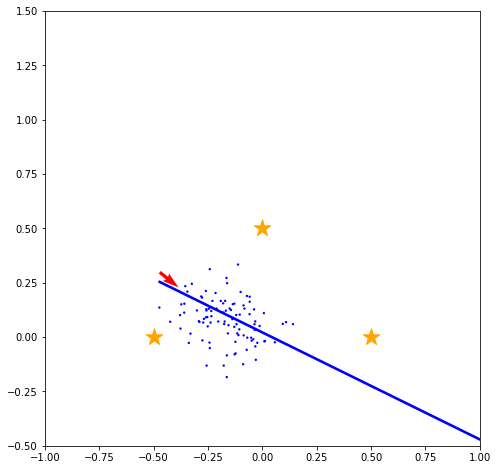

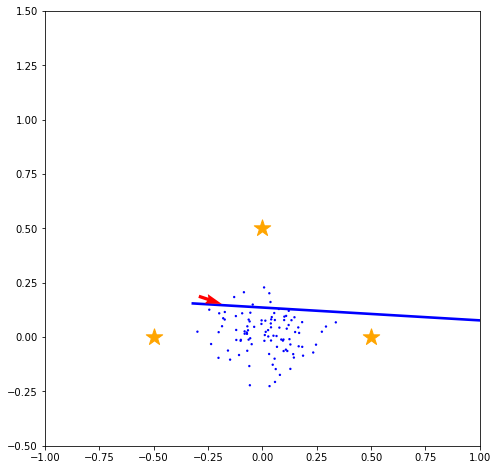

In [33]:
%matplotlib inline
import numpy as np
from copy import copy
import math, random
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse


#ランドマークの作成
actual_landmarks = [np.array([-0.5,0.0]),np.array([0.5,0.0]),np.array([0.0,0.5])]

def draw_landmarks(landmarks):
    xs = [e[0] for e in landmarks]
    ys = [e[1] for e in landmarks]
    plt.scatter(xs,ys,s=300,marker="*",label="landmarks",color="orange")
    
    
#ロボットの作成
actual_x = np.array([0.3,0.2,math.pi*20.0/180])
u = np.array([0.1,10/180*math.pi])

def draw_robot(pose):
    path = [actual_x]
    for i in range(18):
        actual_x = f(actual_x,u)
        path.append(actual_x)
        
    fig = plt.figure(i,figsize=(8,8))
    sp = fig.add_subplot(111, aspect='equal')
    sp.set_xlim(-1.0,1.0)
    sp.set_ylim(-0.5,1.5)
    
    xs = [e[0] for e in path]
    ys = [e[1] for e in path]
    vxs = [math.cos(e[2]) for e in path]
    vys = [math.sin(e[2]) for e in path]
    plt.quiver(xs,ys,vxs,vys,color="red",label="actual robot motion")
    
    plt.quiver([pose[0]],[pose[1]],[math.cos(pose[2])],[math.sin(pose[2])],color="red",label="actual robot motion")
    

#観測モデルの作成
def relative_landmark_pos(pose,landmark):
    x,y,theta = pose
    lx,ly = landmark
    distance = math.sqrt((x-lx)**2 + (y-ly)**2)
    direction = math.atan2(ly-y, lx-x) - theta
    
    return (distance, direction,lx,ly)

measurements = [relative_landmark_pos(actual_x,e) for e in actual_landmarks]
print(measurements)


#描画関数
def draw_observation(pose, measurement):
    x,y,theta = pose
    distance, direction,lx,ly = measurement
    lx = distance*math.cos(theta + direction) + x
    ly = distance*math.sin(theta + direction) + y
    plt.plot([pose[0], lx],[pose[1], ly],color="pink")
    
def draw_observations(pose, measurements):
    for m in measurements:
        draw_observation(pose, m)
        
    
#観測範囲の制限
def observation(pose, landmark):
    actual_distance,actual_direction,lx,ly = relative_landmark_pos(pose,landmark)
    if (math.cos(actual_direction) < 0.0):
        return None
    
    measured_distance = random.gauss(actual_distance,actual_distance*0.1)
    measured_direction = random.gauss(actual_direction,5.0/180.0*math.pi)
    
    return (measured_distance, measured_direction,lx,ly)

def observations(pose,landmarks):
    return filter(lambda x: x != None, [ observation(pose,e) for e in landmarks])

actual_x = np.array([0.3,0.2,math.pi*180.0/180])
measurements = observations(actual_x, actual_landmarks)


#パーティクルの作成
class Particle:
    def __init__(self,w):
        self.pose = np.array([0.0,0.0,0.0])
        self.weight = w
        
    def __repr__(self):
        return "pose: " + str(self.pose) + "weight: " + str(self.weight)
    
def f(x_old,u):
    pos_x, pos_y, pos_theta = x_old
    act_fw, act_rot = u
    
    act_fw = random.gauss(act_fw,act_fw/10)
    dir_error = random.gauss(0.0, math.pi / 180.0 * 3.0)
    act_rot = random.gauss(act_rot,act_rot/10)
    
    pos_x += act_fw * math.cos(pos_theta + dir_error)
    pos_y += act_fw * math.sin(pos_theta + dir_error)
    pos_theta += act_rot
    
    return np.array([pos_x,pos_y,pos_theta])


#描画関数Ⅱ
def draw(pose,particles):
    fig = plt.figure(i,figsize=(8,8))
    sp = fig.add_subplot(111, aspect='equal')
    sp.set_xlim(-1.0,1.0)
    sp.set_ylim(-0.5,1.5)
    
    xs = [e.pose[0] for e in particles]
    ys = [e.pose[1] for e in particles]
    vxs = [math.cos(e.pose[2])*e.weight for e in particles]
    vys = [math.sin(e.pose[2])*e.weight for e in particles]
    plt.quiver(xs,ys,vxs,vys,color="blue",label="particles")
    
    plt.quiver([pose[0]],[pose[1]],[math.cos(pose[2])],[math.sin(pose[2])],color="red",label="acual robot motion")
    
    
#ロボットの移動
actual_x = np.array([0.0,0.0,0.0])
particles = [Particle(1.0/100) for i in range(100)]
u = np.array([0.2,math.pi / 180.0 * 20])

import copy

path = [actual_x]
particle_path = [copy.deepcopy(particles)]
measurementss = [observations(actual_x, actual_landmarks)]
for i in range(18):
    actual_x = f(actual_x,u)
    path.append(actual_x)
    measurementss.append(observations(actual_x,actual_landmarks))
    
    for p in particles:
        p.pose = f(p.pose,u)
    particle_path.append(copy.deepcopy(particles))
    
    
#観測をパーティクルに反映
from scipy.stats import norm
def likelihood(pose, measurement):
    x,y,theta = pose
    distance, direction,lx,ly = measurement
    
    rel_distance, rel_direction, tmp_x,tmp_y = relative_landmark_pos(pose,(lx,ly))
    
    return norm.pdf(x = distance - rel_distance, loc = 0.0, scale = rel_distance / 10.0) \
             * norm.pdf(x = direction - rel_direction, loc = 0.0, scale = 5.0/180.0 * math.pi)

    
#パーティクルの重みを変更する関数
def change_weights(particles, measurement):
    for p in particles:
        p.weight *= likelihood(p.pose, measurement)
        
    ws = [p.weight for p in particles]
    s = sum(ws)
    for p in particles: p.weight = p.weight / s
        
        
#関数の適用
actual_x = np.array([0.0,0.0,0.0])
particles = [Particle(1.0/100) for i in range(100)]
u = np.array([0.2,math.pi / 180.0 * 20])

path = [actual_x]
particle_path = [copy.deepcopy(particles)]
measurementss = [observations(actual_x, actual_landmarks)]
for i in range(18):
    actual_x = f(actual_x,u)
    path.append(actual_x)
    ms = observations(actual_x,actual_landmarks)
    measurementss.append(ms)
    
    for p in particles:
        p.pose = f(p.pose,u)
        
    for m in ms:
        change_weights(particles, m)
    particle_path.append(copy.deepcopy(particles))

for i,p in enumerate(path):
    draw(path[i],particle_path[i])
    draw_landmarks(actual_landmarks)
    draw_observations(path[i],measurementss[i])
    
    
#系統抽出法の実装
class Particle:
    def __init__(self,p,w):
        self.pose = np.array(p)
        self.weight = w
        
    def __repr__(self):
        return "pose: " + str(self.pose) + "weight: " + str(self.weight)
    
for p in particles:
    print(p)
    
    
#確率分布リストの作成
accum = []
sm = 0.0
for p in particles:
    accum.append(p.weight + sm)
    sm += p.weight
    
print(accum)


#サンプリング
pointer = random.uniform(0.0,1.0/len(particles))
print(pointer)

new_particles = []
particles_num = len(particles)

while pointer < 1.0:
    if accum[0] >= pointer:
        new_particles.append(
            Particle(copy.deepcopy(particles[0].pose),1.0/particles_num))
        pointer += 1.0/particles_num
    else:
        accum.pop(0)
        particles.pop(0)
        
particles = new_particles

for p in particles:
    print(p)